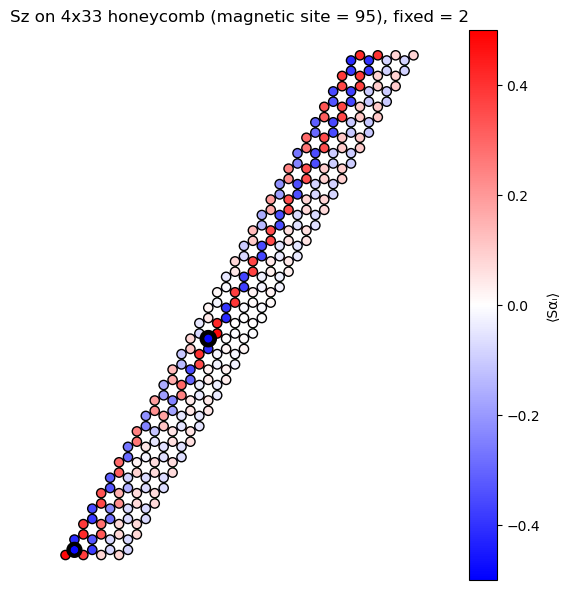

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def honeycomb_bonds(Nx, Ny):
    Nsites = 2 * Nx * Ny
    bonds = []  # (s1, s2, type)
    for i in range(1, Nsites):  # 1..Nsites-1
        if i % 2 == 1:  # odd
            bonds.append((i, i + 1, "xx"))
        else:
            if i <= 2 * Ny * (Nx - 1):
                bonds.append((i, i + 2 * Ny - 1, "yy"))
            if i % (2 * Ny) != 0:
                bonds.append((i, i + 1, "zz"))
    return Nsites, bonds

def honeycomb_positions(Nx, Ny):
    Nsites, bonds = honeycomb_bonds(Nx, Ny)

    a = 1.0
    vx = (np.sqrt(3) * a,  a)   # "xx"
    vy = (np.sqrt(3) * a, -a)   # "yy"
    vz = (0.0,          2 * a)  # "zz"
    vmap = {"xx": vx, "yy": vy, "zz": vz}

    adj = [[] for _ in range(Nsites + 1)]  # 1-indexed
    for s1, s2, bt in bonds:
        v = vmap[bt]
        adj[s1].append((s2, v))
        adj[s2].append((s1, (-v[0], -v[1])))

    pos = np.zeros((Nsites + 1, 2), dtype=float)
    placed = np.zeros(Nsites + 1, dtype=bool)

    # anchor site 1
    pos[1] = (0.0, 0.0)
    placed[1] = True
    queue = [1]

    while queue:
        s = queue.pop(0)
        xs, ys = pos[s]
        for t, v in adj[s]:
            if not placed[t]:
                pos[t] = (xs + v[0], ys + v[1])
                placed[t] = True
                queue.append(t)

    # return 0-indexed array for sites 1..Nsites
    return pos[1:]

def load_component(path):
    with open(path, "r", encoding="utf-8") as f:
        header = f.readline().strip()
    mg_sites = [int(x) for x in header.replace("#", "").split() if x != "i"]

    data = np.loadtxt(path)
    i = data[:, 0].astype(int)
    vals = data[:, 1:]
    return i, vals, mg_sites

def shorten_segment(p1, p2, frac=0.22):
    p1 = np.array(p1, float)
    p2 = np.array(p2, float)
    d = p2 - p1
    return p1 + frac * d, p2 - frac * d

def max_scatter_s_no_overlap(ax, pos_xy, safety=0.85):
    """
    Return scatter marker area 's' (points^2) so circles don't overlap
    given the current axes size.
    """
    disp = ax.transData.transform(pos_xy)  # data -> pixels

    # nearest neighbor distance in pixels (O(N^2); fine for ~few hundred sites)
    dmin2 = np.inf
    for i in range(len(disp)):
        di = disp[i] - disp
        dist2 = di[:, 0]**2 + di[:, 1]**2
        dist2[i] = np.inf
        m = dist2.min()
        if m < dmin2:
            dmin2 = m

    dmin_px = np.sqrt(dmin2)
    diameter_px = dmin_px * safety
    radius_px = diameter_px / 2.0

    dpi = ax.figure.dpi
    radius_pt = radius_px * 72.0 / dpi  # px -> points
    s = np.pi * (radius_pt ** 2)         # area in points^2
    return s

def plot_lattice_values(Nx, Ny, bonds, pos, values,
                        mg_sites=None, mg_site=None,
                        fixed_pos=None, secondspin=False,
                        mark_mg=True, title="", safety=0.82,
                        show_labels="auto"):
    Nsites = 2 * Nx * Ny

    if values.ndim == 2:
        if mg_site is None:
            raise ValueError("Pass mg_site (actual site number) to select a column.")
        if mg_sites is None:
            raise ValueError("mg_sites header list is required when values is 2D.")
        k = mg_sites.index(mg_site)
        v = values[:, k]
    else:
        v = values

    fig = plt.gcf()
    ax = plt.gca()

    bond_color = {"xx": "blue", "yy": "red", "zz": "green"}

    # --- bonds ---
    for s1, s2, bt in bonds:
        p1 = pos[s1 - 1]
        p2 = pos[s2 - 1]
        p1s, p2s = shorten_segment(p1, p2, frac=0.22)
        ax.plot([p1s[0], p2s[0]], [p1s[1], p2s[1]],
                lw=2, color=bond_color[bt], alpha=0.8, zorder=1)

    # Make sure transforms are ready (important before computing pixel distances)
    fig.canvas.draw()

    # --- nodes: compute size so they don't overlap ---
    s_sites = max_scatter_s_no_overlap(ax, pos, safety=safety)

    sc = ax.scatter(pos[:, 0], pos[:, 1], c=v, s=s_sites, edgecolors="k",
                    cmap="bwr", zorder=3, vmin=-0.5, vmax=0.5)
    fig.colorbar(sc, ax=ax, label="⟨Sαᵢ⟩")

    # --- labels ---
    if show_labels == "auto":
        do_labels = (Nsites <= 120)
    else:
        do_labels = bool(show_labels)

    if do_labels:
        for s in range(1, Nsites + 1):
            ax.text(pos[s - 1, 0], pos[s - 1, 1], str(s),
                    ha="center", va="center", fontsize=8,
                    fontweight="bold", zorder=4)

    # --- mark mg site (ring scaled with node size) ---
    if mark_mg and mg_site is not None:
        ax.scatter([pos[mg_site - 1, 0]], [pos[mg_site - 1, 1]],
                   s=s_sites * 2.1, facecolors="none", edgecolors="k",
                   linewidths=3, zorder=5)

    # --- mark fixed_pos if secondspin (second ring, also scaled) ---
    if secondspin and fixed_pos is not None:
        ax.scatter([pos[fixed_pos - 1, 0]], [pos[fixed_pos - 1, 1]],
                   s=s_sites * 1.7, facecolors="none", edgecolors="k",
                   linewidths=3, zorder=6)

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    if mg_site is None:
        ax.set_title(title)
    else:
        extra = f" (magnetic site = {mg_site})"
        if secondspin and fixed_pos is not None:
            extra += f", fixed = {fixed_pos}"
        ax.set_title(f"{title}{extra}")

# ====== run ======
Nx, Ny = 4, 33
secondspin = True
fixed_pos = 2
component = "Sz"
mg_site = 95
yperiodic = "true"

if secondspin:
    filename = f"{component}_2spins_fixed{fixed_pos}"
else:
    filename = f"{component}"

path = f"results/{Nx}x{Ny}_PBC={yperiodic}/Savrg/{filename}.dat"

Nsites, bonds = honeycomb_bonds(Nx, Ny)
pos = honeycomb_positions(Nx, Ny)

i, vals, mg_sites = load_component(path)

plt.figure(figsize=(8, 6))
plot_lattice_values(
    Nx, Ny, bonds, pos, vals,
    mg_sites=mg_sites, mg_site=mg_site,
    fixed_pos=fixed_pos, secondspin=secondspin,
    title=f"{component} on {Nx}x{Ny} honeycomb",
    safety=1.20,         # smaller = more spacing
    show_labels="auto"   # disables labels automatically for big N
)
plt.tight_layout()
plt.show()


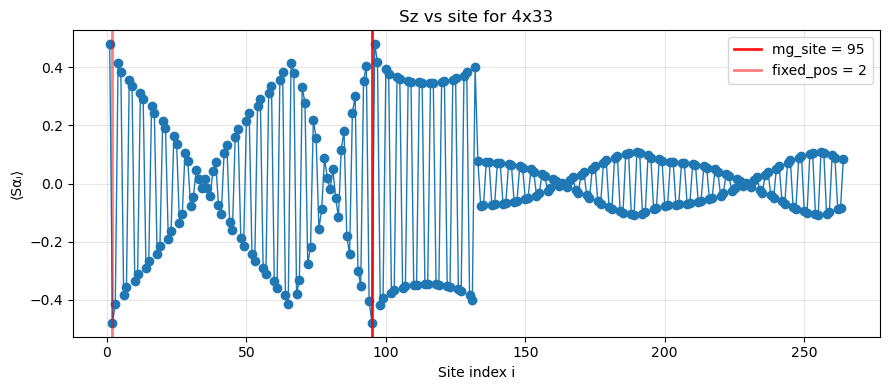

In [57]:
import numpy as np
import matplotlib.pyplot as plt


def load_component(path):
    # header: "# i    2    3   ..."
    with open(path, "r", encoding="utf-8") as f:
        header = f.readline().strip()
    mg_sites = [int(x) for x in header.replace("#", "").split() if x != "i"]

    data = np.loadtxt(path)          # columns: i, col(mg_sites[0]), col(mg_sites[1]), ...
    sites = data[:, 0].astype(int)
    vals = data[:, 1:]
    return sites, vals, mg_sites
def plot_component_vs_site(path, mg_site=None, fixed_pos=None, secondspin=False, title=None):
    sites, vals, mg_sites = load_component(path)

    # pick which column to plot
    if mg_site is None:
        k = 0
        mg_site = mg_sites[k]
    else:
        k = mg_sites.index(mg_site)

    y = vals[:, k]

    plt.figure(figsize=(9, 4))
    plt.plot(sites, y, marker="o", linewidth=1)

    # --- vertical red lines ---
    if mg_site is not None:
        plt.axvline(mg_site, color="red", linewidth=2, alpha=0.9, label=f"mg_site = {mg_site}")
    if secondspin and fixed_pos is not None:
        plt.axvline(fixed_pos, color="red", linewidth=2, alpha=0.5, label=f"fixed_pos = {fixed_pos}")

    plt.xlabel("Site index i")
    plt.ylabel("⟨Sαᵢ⟩")
    plt.title(title or f"{path}   (magnetic site = {mg_site})")
    plt.grid(True, alpha=0.3)

    # show legend only if we actually added lines
    if (mg_site is not None) or (secondspin and fixed_pos is not None):
        plt.legend()

    plt.tight_layout()
    plt.show()


if secondspin:
    filename = f"{component}_2spins_fixed{fixed_pos}"
else:
    filename = f"{component}"

path = f"results/{Nx}x{Ny}_PBC={yperiodic}/Savrg/{filename}.dat"
plot_component_vs_site(
    path,
    mg_site=mg_site,
    fixed_pos=fixed_pos,
    secondspin=secondspin,
    title=f"{component} vs site for {Nx}x{Ny}"
)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def load_component(path):
    with open(path, "r", encoding="utf-8") as f:
        header = f.readline().strip()
    mg_sites = [int(x) for x in header.replace("#", "").split() if x != "i"]

    data = np.loadtxt(path)
    sites = data[:, 0].astype(int)
    vals = data[:, 1:]  # (Nsites, ncfg)
    return sites, vals, mg_sites

def animate_component_vs_site(path, fixed_pos=None, secondspin=False,
                              interval=250, repeat=True, save=None):
    sites, vals, mg_sites = load_component(path)

    # --- sort mg_sites and reorder columns accordingly ---
    order = np.argsort(mg_sites)
    mg_sites_sorted = [mg_sites[i] for i in order]
    vals_sorted = vals[:, order]

    fig, ax = plt.subplots(figsize=(9, 4))

    # start: first sorted mg_site
    k0 = 0
    (line,) = ax.plot(sites, vals_sorted[:, k0], marker="o", linewidth=1)

    # vertical lines
    vline_mg = ax.axvline(mg_sites_sorted[k0], color="red", linewidth=2, alpha=0.9)
    vline_fixed = None
    if secondspin and fixed_pos is not None:
        vline_fixed = ax.axvline(fixed_pos, color="red", linewidth=2, alpha=0.4)

    ax.set_xlabel("Site index i")
    ax.set_ylabel("⟨Sαᵢ⟩")
    ax.set_xlim(sites.min(), sites.max())
    ax.grid(True, alpha=0.3)

    # --- fixed y-limits for spin-1/2 components ---
    ax.set_ylim(-0.6, 0.6)

    def update(frame):
        k = frame % len(mg_sites_sorted)
        line.set_ydata(vals_sorted[:, k])

        mg = mg_sites_sorted[k]
        vline_mg.set_xdata([mg, mg])

        title = f"{path}   (magnetic site = {mg})"
        if secondspin and fixed_pos is not None:
            title += f", fixed = {fixed_pos}"
        ax.set_title(title)

        return (line, vline_mg) if vline_fixed is None else (line, vline_mg, vline_fixed)

    anim = FuncAnimation(fig, update, frames=len(mg_sites_sorted),
                         interval=interval, blit=False, repeat=repeat)

    plt.tight_layout()

    if save is not None:
        fps = max(1, 1000 // interval)
        if save.lower().endswith(".gif"):
            anim.save(save, writer="pillow", fps=fps)
        elif save.lower().endswith(".mp4"):
            anim.save(save, writer="ffmpeg", fps=fps)
        else:
            raise ValueError("save must end with .gif or .mp4")

    plt.show()
    return anim

animate_component_vs_site(
    path,
    fixed_pos=fixed_pos,
    secondspin=secondspin,
    interval=250,
    save=f"{filename}.gif"  # albo "Sz.mp4" / "Sz.gif"
)

FileNotFoundError: [Errno 2] No such file or directory: 'results/4x33_PBC=true/Savrg/Sz_2spins_fixed2.gif'